## Download kaggle data in Google Colab

In [1]:
# Peso (7.19 GB)
!kaggle datasets download -d anirudhcv/labeled-optical-coherence-tomography-oct

Dataset URL: https://www.kaggle.com/datasets/anirudhcv/labeled-optical-coherence-tomography-oct
License(s): unknown
100% 6.69G/6.70G [01:29<00:00, 95.3MB/s]
100% 6.70G/6.70G [01:29<00:00, 80.3MB/s]


In [2]:
!unzip -q /content/labeled-optical-coherence-tomography-oct.zip -d /content
!rm /content/labeled-optical-coherence-tomography-oct.zip

## Import libraries

In [3]:
import os
import random
import matplotlib.image as mpimg
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
from skimage import exposure
from skimage.io import imread
import cv2
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import timm
import time
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,balanced_accuracy_score
import seaborn as sns


## Functions

### Cargar y entrenar

In [4]:
# Definir transformaciones para los conjuntos de datos
def get_transforms(input_size):
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(input_size), # las tres arquitecturas tienen entrada de 224x224
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize(input_size + 32),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize(input_size + 32),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }
    return data_transforms

# Función para cargar los datos
def load_data(input_size, batch_size=32):
    data_transforms = get_transforms(input_size)
    image_datasets = {
        'train': datasets.ImageFolder(train_dir, data_transforms['train']),
        'val': datasets.ImageFolder(val_dir, data_transforms['val']),
        'test': datasets.ImageFolder(test_dir, data_transforms['test'])
    }
    dataloaders = {
        x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=(x == 'train'), num_workers=4, pin_memory=True)
        for x in ['train', 'val', 'test']
    }
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
    class_names = image_datasets['train'].classes
    return dataloaders, dataset_sizes, class_names

# Función para entrenar el modelo
def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=25, model_name=''):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    # Ruta para guardar el modelo por si se desconecta la sesión
    model_save_path = os.path.join(f'{model_name}_checkpoint.pth')

    for epoch in range(num_epochs):
        print('Época {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Cada época tiene una fase de entrenamiento y validación
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Establecer el modelo en modo de entrenamiento
            else:
                model.eval()   # Establecer el modelo en modo de evaluación

            running_loss = 0.0
            running_corrects = 0

            # Iterar sobre los datos
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

                # Poner a cero los gradientes del optimizador
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Función de perdida
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Pérdida: {:.4f} Precisión: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Copiar el modelo si hay mejora en la precisión
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        # Guardar modelo después de cada época
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_model_wts': best_model_wts,
            'best_acc': best_acc,
            'model_name': model_name,
        }
        torch.save(checkpoint, model_save_path)
        print(f"Modelo guardado en la época {epoch + 1} en: {model_save_path}")

        print()

    time_elapsed = time.time() - since
    print('Entrenamiento completo en {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Mejor precisión en validación: {:4f}'.format(best_acc))

    # Cargar los mejores pesos del modelo
    model.load_state_dict(best_model_wts)
    return model


# Función para evaluar el modelo en el conjunto de prueba
def test_model(model, dataloader, dataset_size):
    model.eval()
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            running_corrects += torch.sum(preds == labels.data)

    acc = running_corrects.double() / dataset_size
    print('Precisión en el conjunto de prueba: {:.4f}'.format(acc))

# Función principal para entrenar un modelo específico
def main(model_name, num_classes=4, num_epochs=25, batch_size=32):
    input_size = 224
    #Cargar la base de datos con los parámetros necesarios
    dataloaders, dataset_sizes, class_names = load_data(input_size, batch_size)

    # Cargar el modelo preentrenado y modificarlo para la clasificación de 4 clases
    if model_name == 'resnet':
        model = models.resnet50(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name == 'convnext':
        model = timm.create_model('convnext_tiny', pretrained=True, num_classes=num_classes)  # ConvNeXt Tiny
    elif model_name == 'swin_transformer':
        model = timm.create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=num_classes)
    else:
        print('Modelo no soportado')
        return

    model = model.to(device)

    criterion = nn.CrossEntropyLoss()

    # Optimizador
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    # optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Scheduler: CosineAnnealingLR
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)
    # scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

    # Entrenar el modelo
    model = train_model(model, criterion, optimizer, scheduler,
                        dataloaders, dataset_sizes, num_epochs=num_epochs, model_name=model_name)

    # Evaluar el modelo en el conjunto de prueba
    test_model(model, dataloaders['test'], dataset_sizes['test'])

    # Guardar el modelo en Google Drive
    model_path = os.path.join(f'{model_name}_best_model.pth')
    torch.save(model.state_dict(), model_path)
    print(f"Modelo guardado en: {model_path}")

### Pruebas y visualización de resultados

In [10]:
# Definir la función para cargar el modelo
def load_model(model_path, model_name, num_classes=4):
    if model_name == 'resnet':
        model = models.resnet50(pretrained=False)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name == 'convnext':
        model = timm.create_model('convnext_tiny', pretrained=False, num_classes=num_classes)
    elif model_name == 'swin_transformer':
        model = timm.create_model('swin_base_patch4_window7_224', pretrained=False, num_classes=num_classes)
    else:
        raise ValueError('Modelo no soportado')

    # Cargar solo los pesos
    try:
        checkpoint = torch.load(model_path, map_location=device)

        if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
            # Caso: El archivo es un checkpoint completo
            model.load_state_dict(checkpoint['model_state_dict'])
            print("Checkpoint cargado correctamente.")
        else:
            # Caso: El archivo contiene directamente los pesos
            model.load_state_dict(checkpoint)
            print("Pesos del modelo cargados correctamente.")
    except Exception as e:
        print(f"No se pudo cargar el modelo desde {model_path}. Error: {e}")
        return None
    model = model.to(device)
    model.eval()
    return model


# Mostrar imágenes y sus predicciones
def visualize_predictions(model, dataloader, class_names, num_images=10):
    model.eval()
    images_so_far = 0
    plt.figure(figsize=(20, 10))

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size(0)):
                images_so_far += 1
                ax = plt.subplot(num_images // 5, 5, images_so_far)
                ax.axis('off')
                ax.set_title(f"Pred: {class_names[preds[j]]}\nLabel: {class_names[labels[j]]}")
                img = inputs[j].cpu().numpy().transpose((1, 2, 0))
                img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Desnormalizar
                img = np.clip(img, 0, 1)
                plt.imshow(img)

                if images_so_far == num_images:
                    plt.show()
                    return

# Función para evaluar el modelo y calcular las métricas
def evaluate_model(model, dataloader, dataset_size, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            running_corrects += torch.sum(preds == labels.data)

    # Calcular métricas
    accuracy = accuracy_score(all_labels, all_preds)
    balanced_accuracy = balanced_accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    # Imprimir las métricas
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    # Calcular la matriz de confusión
    cm = confusion_matrix(all_labels, all_preds)

    return accuracy, balanced_accuracy, precision, recall, f1, cm, class_names

# Función para graficar la matriz de confusión
def plot_confusion_matrix(cm, class_names):
    # Normalizar la matriz de confusión
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Crear subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Matriz de confusión normal
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[0])
    axes[0].set_title('Confusion Matrix')
    axes[0].set_xlabel('Predicted Labels')
    axes[0].set_ylabel('True Labels')

    # Matriz de confusión normalizada
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[1])
    axes[1].set_title('Normalized Confusion Matrix')
    axes[1].set_xlabel('Predicted Labels')
    axes[1].set_ylabel('True Labels')

    plt.tight_layout()
    plt.show()

## Cargar datos

In [6]:
# Detectar dispositivo
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo en uso: {device}")

# Directorios de datos
data_dir = '/content/Dataset - train+val+test/'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

Dispositivo en uso: cuda:0


# Entrenamiento

In [8]:
# Entrenar 3 arquitecturas con todos los datos para explorar tiempo de entrenamiento
for model_name in ['resnet']: # ,'swin_transformer','convnext'
    print(f'Training model: {model_name}')
    main(model_name=model_name, num_classes=4, num_epochs=1, batch_size=32)

Training model: resnet
Época 1/1
----------
train Pérdida: 0.1500 Precisión: 0.9503
val Pérdida: 0.1020 Precisión: 0.9659
Modelo guardado en la época 1 en: resnet_checkpoint.pth

Entrenamiento completo en 14m 41s
Mejor precisión en validación: 0.965921
Precisión en el conjunto de prueba: 0.9643
Modelo guardado en: resnet_best_model.pth


# Prueba

In [11]:
# Configuraciones
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model_name = "convnext"
# model_name = "swin_transformer"
model_name = "resnet"
model_path = f"{model_name}_best_model.pth"
input_size = 224  # Tamaño de entrada de las 3 arquitecturas
batch_size = 32

# Transformaciones y conjunto de datos de prueba
data_transforms = get_transforms(input_size)
test_dataset = ImageFolder(test_dir, transform=data_transforms['test'])
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Cargar el modelo
model = load_model(model_path, model_name)

<ipython-input-10-455da49db6e5>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Pesos del modelo cargados correctamente.


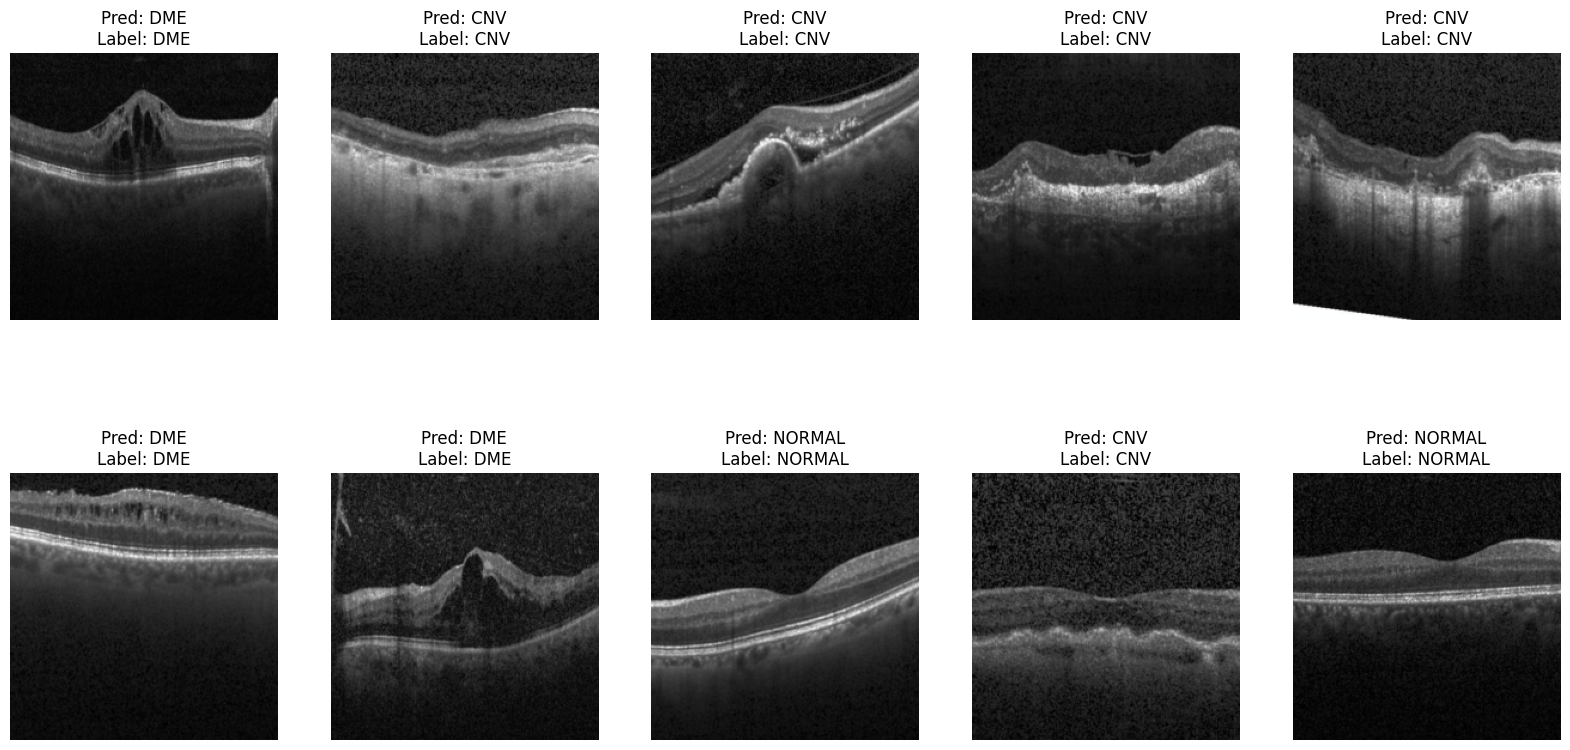

In [12]:
# Visualizar predicciones
visualize_predictions(model, test_dataloader, test_dataset.classes, num_images=10)

Accuracy: 0.9643
Balanced Accuracy: 0.9306
Precision: 0.9638
Recall: 0.9643
F1-score: 0.9639


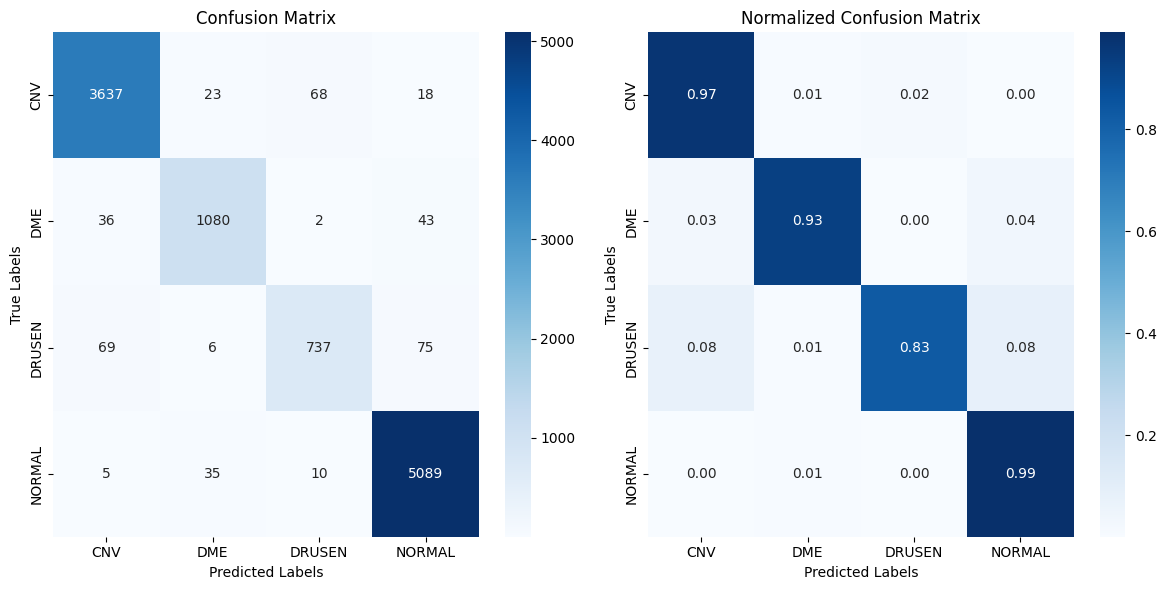

In [13]:
# Evaluar el modelo
accuracy, precision, recall, f1, sensitivity,cm, class_names = evaluate_model(model, test_dataloader, len(test_dataset), test_dataset.classes)
# Calcular la matriz de confusión
plot_confusion_matrix(cm, class_names)